# Importing Libraries and Modules

In [1]:
import numpy as np
import torch
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

from capsnet import CapsNet
from capsnet import ObjectCaps
from capsnet.config import MNIST

### Failure on Import

If some of the modules are missing we can install them by uncomenting the following cell and running it.

In [2]:
# !pip install torch torchvision tqdm numpy

# Defining the Training Function

We define the training of the entrie Capsule network, using the capsnet library.

In [3]:
def train(capsule_net, optimizer, data_loader, epoch, device=torch.device("cpu")):
    capsule_net.to(device)
    capsule_net.train()

    # Calculate the number of batches
    n_batch = np.ceil(len(data_loader.dataset) / data_loader.batch_size)
    total_loss = 0

    for i, (batch_image, batch_label) in enumerate(tqdm(data_loader)):
        batch_image, batch_label = batch_image.to(device), batch_label.to(device)

        optimizer.zero_grad()
        batch_obj_vectors, batch_reconstruction, batch_y_prob = capsule_net(batch_image, batch_label)
        loss = capsule_net.loss(batch_y_prob, batch_label, batch_image, batch_reconstruction)
        loss.backward()
        optimizer.step()

        # Calculate and print training accuracy and loss
        accuracy = np.mean(
            np.argmax(batch_y_prob.detach().cpu().numpy(), 1) == batch_label.cpu().numpy()
        )
        total_loss += loss.item()
        avg_loss = loss.item() / float(data_loader.batch_size)

        if i % 100 == 0:
            tqdm.write(
                f"Epoch: [{epoch}], Batch: [{i + 1}/{n_batch}], train accuracy: {accuracy:.6f}, "
                f"loss: {avg_loss:.6f}"
            )


# Defining the Evaluating Function

We define the evaluation of the entrie Capsule network, using the capsnet library.

In [4]:
def evaluate(capsule_net, data_loader, epoch, device=torch.device("cpu")):
    capsule_net.to(device)
    capsule_net.eval()

    # Calculate the number of batches
    n_batch = np.ceil(len(data_loader.dataset) / data_loader.batch_size)
    with torch.no_grad():
        total_loss = 0
        for i, (batch_image, batch_label) in enumerate(tqdm(data_loader)):
            batch_image, batch_label = batch_image.to(device), batch_label.to(device)

            batch_obj_vectors, batch_reconstruction, batch_y_prob = capsule_net(batch_image)
            loss = capsule_net.loss(batch_y_prob, batch_label, batch_image, batch_reconstruction)

            # Calculate and print test accuracy and loss
            accuracy = np.mean(
                np.argmax(batch_y_prob.detach().cpu().numpy(), 1) == batch_label.cpu().numpy()
            )
            total_loss += loss.item()
            avg_loss = loss.item() / float(data_loader.batch_size)

            if i % 100 == 0:
                tqdm.write(
                    f"Epoch: [{epoch}], Batch: [{i + 1}/{n_batch}], test accuracy: {accuracy:.6f}, "
                    f"loss: {avg_loss:.6f}"
                )


# Main Training and Testing Loops

We have set up a **train_capsnet** flag and set it to ```False``` to avoidd training the large model.
If you wish to retrain the model set it to ```True```.

We have also included a pre-trained capsnet model in the variable **saved_model_name** we used to generate all our results included in the trainng. The name of the saved model is ```'final_model.pth'```

Should you choose to re-train the model, the new model will be saved as ```'final_model_new.pth'``` to avoid overwrting the previously trained model

In [5]:
train_capsnet = False  # Set False to avoid the training, it took about 30 mins for all 10 epochs to finish training
saved_model_name = 'final_model.pth'  # Name of the Saved Pre-trained-Model Included in the project

In [6]:
BATCH_SIZE = 128
EPOCHS = 10
LEARNING_RATE = 0.01
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
DATASET_CONFIG = MNIST

# Define dataset transformations
dataset_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST train and test datasets
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=dataset_transform)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=dataset_transform)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
singleton_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

# Set a random seed for reproducibility
torch.manual_seed(1)

# Initialize Capsule Network and optimizer
capsule_net = CapsNet(**DATASET_CONFIG)
capsule_net.to(DEVICE)
optimizer = torch.optim.Adam(capsule_net.parameters(), lr=LEARNING_RATE)

# Training loop
if(train_capsnet):  # If we train we save the model, for redundency we have a new keyword added. to the model so our trained model is not overwritten
    for e in range(1, 1 + EPOCHS):
        train(capsule_net, optimizer, train_loader, e, device=DEVICE)
        evaluate(capsule_net, test_loader, e, device=DEVICE)

    # Visualize predictions on the test dataset
    visualize_predictions(capsule_net, test_loader, device=DEVICE)
    torch.save(capsule_net, 'final_model_new.pth')
                        

100%|███████████████████████████| 9912422/9912422 [00:00<00:00, 15733452.53it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|███████████████████████████████| 28881/28881 [00:00<00:00, 26788079.13it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|████████████████████████████| 1648877/1648877 [00:00<00:00, 5112271.71it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████████████████████████████| 4542/4542 [00:00<00:00, 3753798.77it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Defining the Visualization Function

Here we created a function that traverses the capsulenet layers, and the final decoder layer to reuturn the reconstructed image, as well print the pose parameters learned.

In [7]:
def visualize_predictions(capsule_net, data_loader, device=torch.device("cpu"), limit=20):
    capsule_net.to(device)
    capsule_net.eval()
        
    with torch.no_grad():
        for i, (batch_image, batch_label) in enumerate(data_loader):
            batch_image, batch_label = batch_image.to(device), batch_label.to(device)

            obj_vectors, reconstructed_image, batch_y_prob = capsule_net(batch_image)

            # Visualize a random sample from the batch
            index = np.random.randint(0, batch_image.size(0))
            image = batch_image[index].cpu().numpy().squeeze()
            predicted_label = np.argmax(batch_y_prob[index].cpu().numpy())
            
            # Create a figure with two subplots
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(4, 2))
            print(f"Instantiation Parameter for {predicted_label}:\n ",obj_vectors[0,predicted_label,:,0])

            # Plot the first image
            ax1.imshow(image, cmap='gray')
            ax1.set_title(f"Original Image\nTrue Label: {batch_label[index]}")
            ax1.axis('Off')

            # Plot the second image
            r_image = reconstructed_image[index].cpu().numpy().squeeze()
            ax2.imshow(r_image, cmap='gray')
            ax2.set_title(f"Reconstructed Image\nPredicted Label: {predicted_label}")
            ax2.axis('Off')

            # Adjust layout for better spacing
            plt.tight_layout()

            # Show the plot
            plt.show()
            
            if(i==limit-1 and data_loader.batch_size == 1):
                break  # Break after visualizing one batch


# Defining the Perturbation Functions

For each predicted image we modify the pose parameters and inject it into the decoder network to show the generated the perturbations.
How to Interpret the final output here:
- The rows represent the pose_parameters learnt for the images
- The collumns represent the minute perturbations introduced in the parameter, the perturbations are linear in our case ranging from `-0.2` to `+0.2`

In [8]:
def visualize_perturbations(capsule_net, data_loader, device=torch.device("cpu"), limit=1, n_steps=11):
    capsule_net.to(device)
    capsule_net.eval()
        
    with torch.no_grad():
        for idx, (batch_image, batch_label) in enumerate(data_loader):
            batch_image, batch_label = batch_image.to(device), batch_label.to(device)

            obj_vectors, _, batch_y_prob = capsule_net(batch_image)

            # Visualize a random sample from the batch
            index = np.random.randint(0, batch_image.size(0))
            image = batch_image[index].cpu().numpy().squeeze()
            print(image.shape)
            predicted_label = np.argmax(batch_y_prob[index].cpu().numpy())
            
            steps = np.linspace(-0.2, 0.2, n_steps) # -0.25, -0.15, ..., +0.25
            pose_nums = np.arange(16) # 0, 1, ..., 15
            
            plt.subplots_adjust(wspace=0.1, hspace=0.1)

            fig, axis = plt.subplots(16, 11, figsize=(8,12))
            fig.suptitle(f"Perturbations for {predicted_label}", fontsize=18)
            
            # Modifying obj_vectors that contains the pose information
            for i, p in enumerate(pose_nums):
                for j, step in enumerate(steps):
                    obj_vectors[0, int(predicted_label), :, 0] += step*torch.eye(16, 16)[int(p),:]
                    _, r_image, p_label = capsule_net.forward(image, obj_vectors=obj_vectors)

                    p_image=r_image[index].cpu().numpy().squeeze()
                    axis[i,10-j].imshow(p_image, cmap='gray')
                    axis[i,10-j].axis('Off')
            
            # Adjust layout to prevent clipping
            plt.tight_layout()

            # Show the plot
            plt.show()
            if(idx==limit-1):
                return  # Break after visualizing one batch


# Running VIsualizations/Reconstruction from the Testing Set

Instantiation Parameter for 8:
  tensor([ 0.0119, -0.9491,  0.0185,  0.0021,  0.0034,  0.0388, -0.0031,  0.0101,
        -0.0034, -0.0134, -0.0196, -0.0838, -0.0334,  0.0147, -0.0022,  0.0202])


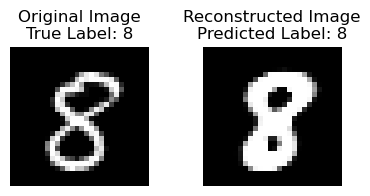

Instantiation Parameter for 2:
  tensor([ 0.0299, -0.2823,  0.6649, -0.0399, -0.1794, -0.0091,  0.0258, -0.0667,
        -0.1992,  0.1597, -0.5331, -0.0553, -0.1192, -0.0040,  0.0595, -0.0014])


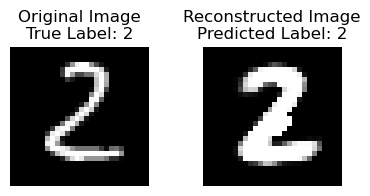

Instantiation Parameter for 1:
  tensor([ 0.3998,  0.1491, -0.3305, -0.1486, -0.1594,  0.2561,  0.1786, -0.0601,
        -0.0156, -0.1857, -0.0674, -0.4275,  0.0650,  0.3944,  0.0465,  0.1679])


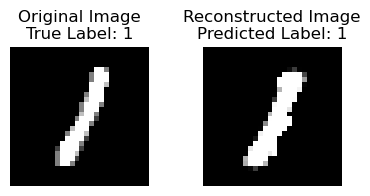

In [9]:
# Load the model
if(train_capsnet):  # Checking the trining flag to see which model to use.
    saved_model_name = 'final_model_new.pth'
    
loaded_model = torch.load(saved_model_name)

visualize_predictions(loaded_model, singleton_loader, device=DEVICE,limit=3)

(28, 28)


<Figure size 640x480 with 0 Axes>

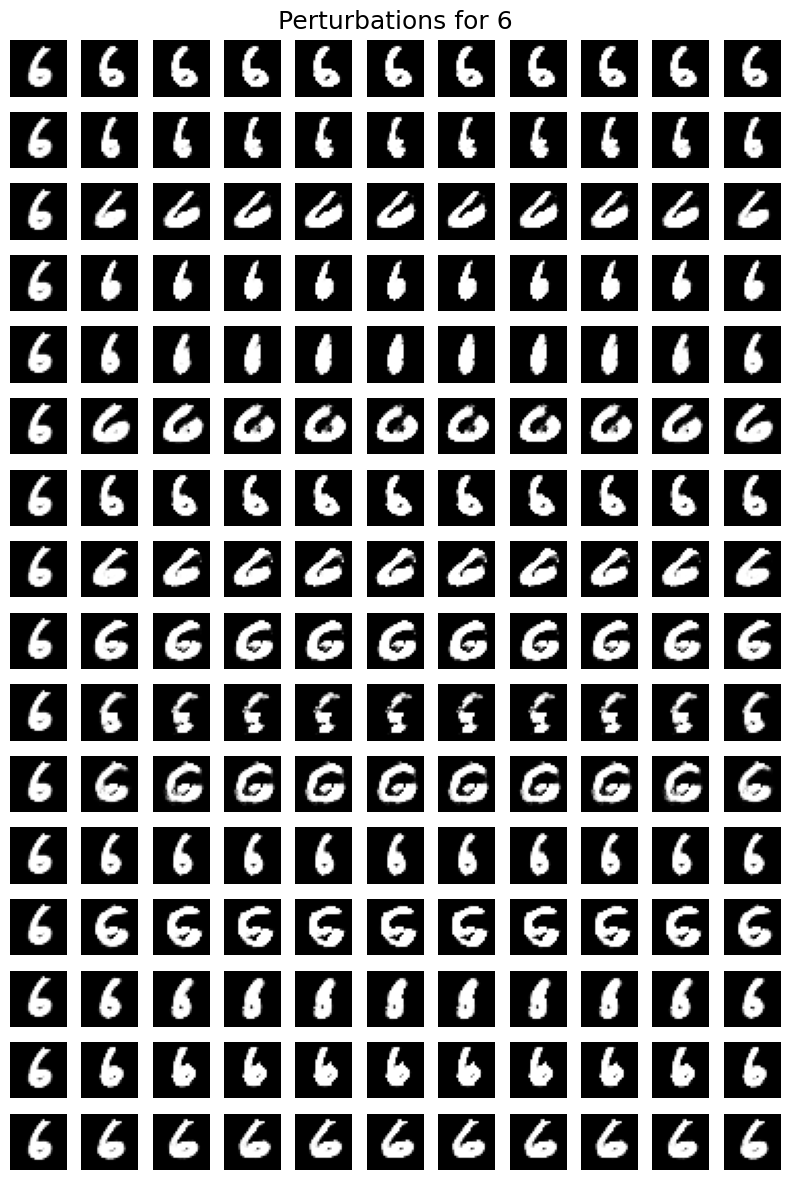

(28, 28)


<Figure size 640x480 with 0 Axes>

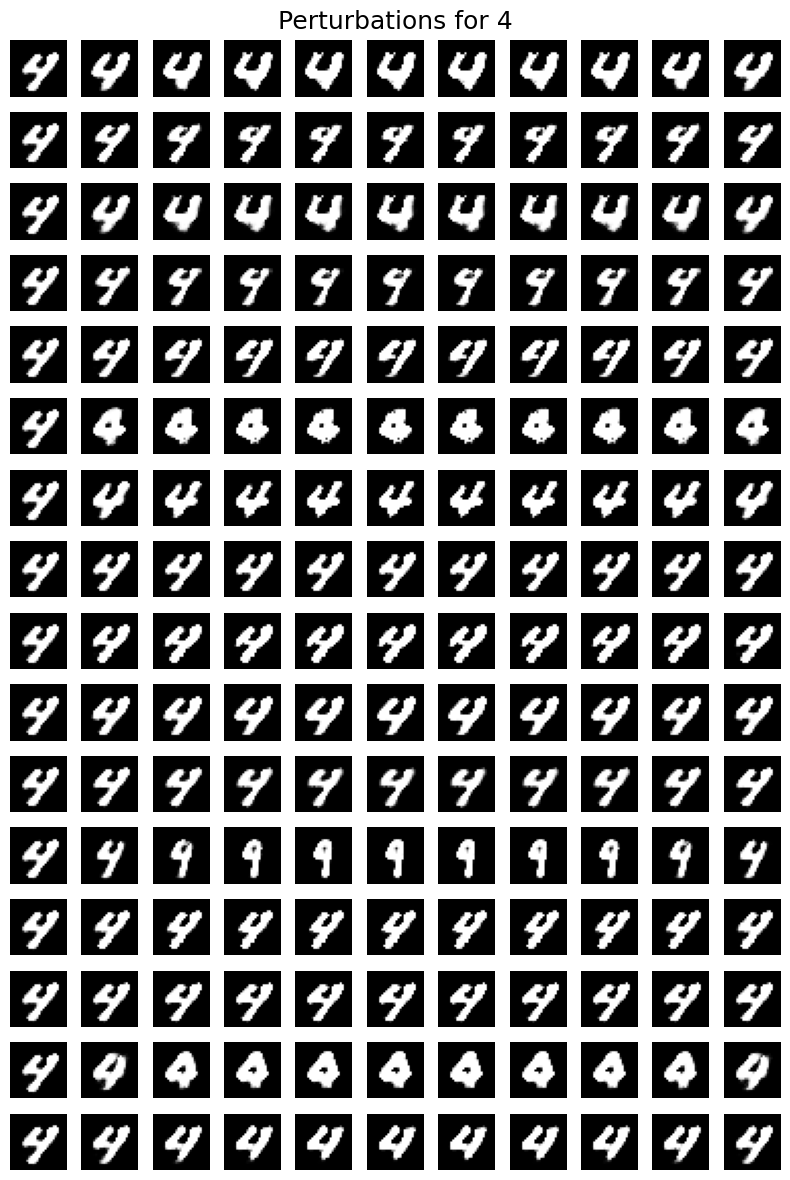

(28, 28)


<Figure size 640x480 with 0 Axes>

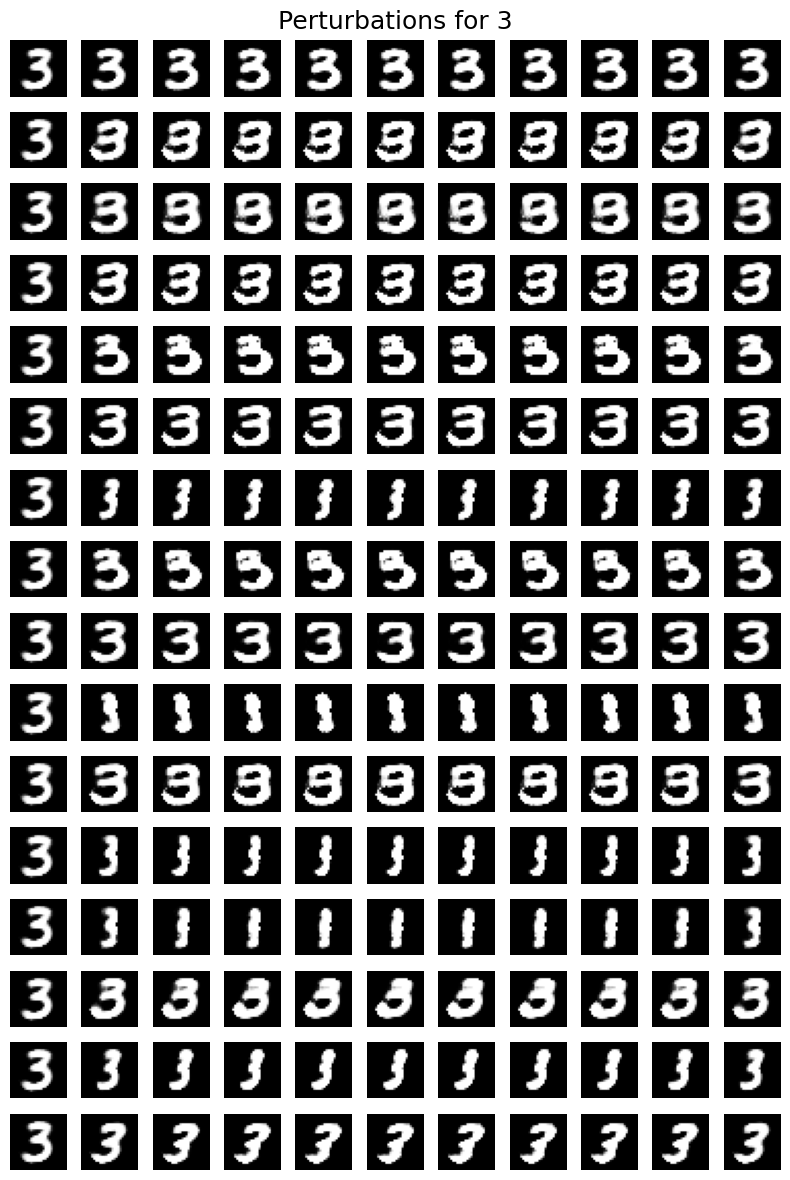

In [10]:
visualize_perturbations(loaded_model, singleton_loader, device=DEVICE, limit=3)